In [0]:
import os
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2

from google.colab.patches import cv2_imshow

In [0]:
# Input layers
input1 = tf.keras.layers.Input(shape=(160,160,3))
input2 = tf.keras.layers.Input(shape=(160,160,3))

# Sequential Layers
sequential_layers = tf.keras.models.Sequential()
sequential_layers.add(tf.keras.layers.Conv2D(64, (10, 10), activation='relu', input_shape=(160,160,3)))
sequential_layers.add(tf.keras.layers.MaxPool2D())
sequential_layers.add(tf.keras.layers.Conv2D(128, (7, 7), activation='relu'))
sequential_layers.add(tf.keras.layers.MaxPool2D())
sequential_layers.add(tf.keras.layers.Conv2D(128, (4, 4), activation='relu'))
sequential_layers.add(tf.keras.layers.MaxPool2D())
sequential_layers.add(tf.keras.layers.Conv2D(256, (4, 4), activation='relu'))
sequential_layers.add(tf.keras.layers.Flatten())
sequential_layers.add(tf.keras.layers.Dense(128, activation='relu'))

# 128 dim vector encodings for both inputs
input1_encoding = sequential_layers(input1)
input2_encoding = sequential_layers(input2)

# A layer to calculate the L2 norm of the two encodings
l2_layer = tf.keras.layers.Lambda(lambda vectors: tf.keras.backend.abs(vectors[0] - vectors[1]))
l2_distance = l2_layer([input1_encoding, input2_encoding])

# Prediction layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(l2_distance)

# Connecting all the layers together
siamese_net = tf.keras.models.Model(inputs = [input1, input2], outputs = prediction)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Model Architecture
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          5926336     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           sequential[1][0]             

In [0]:
# Preparing the dataset

# Get all the filenames
filename = []

# For each dir in ./data/train
for label in os.listdir(os.path.join(os.getcwd(), 'data')):
  # For each img the the label dir
  for image in os.listdir(os.path.join(os.getcwd(), 'data', label)):
    # Add the filename to a list
    filename.append(os.path.join(os.getcwd(), 'data', label, image))

In [0]:
# Creating pair of images

f1 = []
f2 = []
y = []

# Iterating over the combination of images
for i,j in combinations(filename,2):
  
  # Read the images
  img1 = cv2.imread(i)
  img2 = cv2.imread(j)
  
  # Resize the images to 160 x 160
  img1 = cv2.resize(img1, (160, 160))
  img2 = cv2.resize(img2, (160, 160))
  
  # Normalize the image matrices
  img1 = img1.astype('float')/255
  img2 = img2.astype('float')/255
  
  # If the image is of the same person, then the label is 1 otherwise 0
  label = 1 if i.split('/')[-2] == j.split('/')[-2] else 0

  # Add all images and labels to a list
  f1.append(img1)
  f2.append(img2)
  y.append(label)

In [0]:
# Shuffle the list to add some variability to the list
f1, f2, y = shuffle(f1, f2, y)

In [0]:
# Train test Split

# Total data: 780
# Training data: 624 (80%)
# Testing data: 156 (20%)

# Getting the training data
f1_train = f1[:624]
f2_train = f2[:624]
y_train = y[:624]

# Getting the testing data
f1_test = f1[624:]
f2_test = f2[624:]
y_test = y[624:]

In [0]:
# Compiling the neural network
# Loss function: binary_crossentropy
# optimizer: adam
# Evaluation metric: Accuracy score
siamese_net.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.00006), metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Training the data
# Batch size: 24
# Epochs: 10
hist = siamese_net.fit([f1_train ,f2_train], y_train, epochs=15, shuffle=True, batch_size=24)

Train on 624 samples
Epoch 1/15
624/624 [==============================] - 15s 24ms/sample - loss: 0.6025 - acc: 0.7548
Epoch 2/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.5282 - acc: 0.7837
Epoch 3/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.4336 - acc: 0.7837
Epoch 4/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.3521 - acc: 0.7837
Epoch 5/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.3044 - acc: 0.7837
Epoch 6/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.2700 - acc: 0.7837
Epoch 7/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.2425 - acc: 0.7917
Epoch 8/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.1703 - acc: 0.8990
Epoch 9/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.1243 - acc: 0.9359
Epoch 10/15
624/624 [==============================] - 9s 15ms/sample - loss: 0.1022 - acc: 0.94

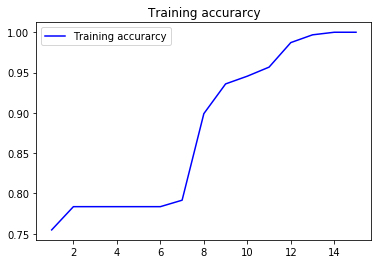

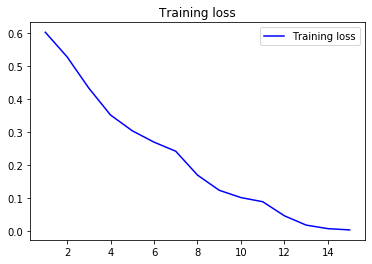

In [0]:
acc = hist.history['acc']
loss = hist.history['loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.title('Training accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [0]:
siamese_net.evaluate([f1_test, f2_test], y_test)

156/156 [==============================] - 3s 19ms/sample - loss: 0.0374 - acc: 0.9872


[0.03744560671158326, 0.98717946]

In [0]:
# Testing on same image
img1 = cv2.imread('aayush_x.jpg')
img2 = cv2.imread('aayush_5.jpg')

In [0]:
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))

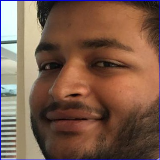

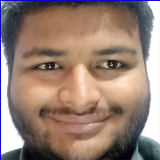

In [0]:
cv2_imshow(img1)
cv2_imshow(img2)

In [0]:
img1 = img1.astype('float')/255
img2 = img2.astype('float')/255

In [0]:
f1 = [img1]
f2 = [img2]

In [0]:
siamese_net.predict([f1,f2])[0][0]  # Correct prediction

0.99989974

In [0]:
img1 = cv2.imread('aayush_5.jpg')
img2 = cv2.imread('aayush_10.jpg')

In [0]:
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))

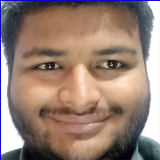

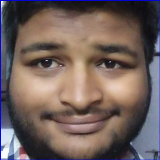

In [0]:
cv2_imshow(img1)
cv2_imshow(img2)

In [0]:
img1 = img1.astype('float')/255
img2 = img2.astype('float')/255

In [0]:
f1 = [img1]
f2 = [img2]

In [0]:
siamese_net.predict([f1,f2])

array([[0.984677]], dtype=float32)

In [0]:
# Testing on different image
img1 = cv2.imread('person_1.jpg')
img2 = cv2.imread('harshal_9.jpg')

In [0]:
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))

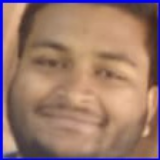

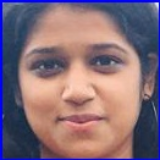

In [0]:
cv2_imshow(img1)
cv2_imshow(img2)

In [0]:
img1 = img1.astype('float')/255
img2 = img2.astype('float')/255

In [0]:
f1 = [img1]
f2 = [img2]

In [0]:
siamese_net.predict([f1,f2])

array([[2.1658302e-06]], dtype=float32)

In [0]:
img1 = cv2.imread('person_1.jpg')
img2 = cv2.imread('muskan_3.jpg')

In [0]:
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))

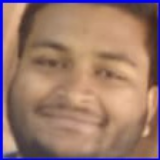

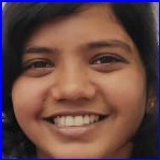

In [0]:
cv2_imshow(img1)
cv2_imshow(img2)

In [0]:
img1 = img1.astype('float')/255
img2 = img2.astype('float')/255
f1 = [img1]
f2 = [img2]
siamese_net.predict([f1,f2])

array([[0.]], dtype=float32)

In [0]:
with open('model.pkl', 'wb') as f:
  pickle.dump(siamese_net, f)

In [0]:
siamese_net.save_weights('model_weights.hdf5')

In [0]:
model_json = siamese_net.to_json()

In [0]:
with open('siamese_net.json', 'w') as f:
  f.write(model_json)

In [0]:
siamese_net.save('model.h5')